In [64]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df


In [25]:
df_pull = pullsqldata()


In [57]:
upper_range = 2*df_pull['saleprice'].std() + df_pull['saleprice'].mean()

df = df_pull[(df_pull['saleprice']> 10000) & (df_pull['saleprice'] < upper_range )]
# df = df[(df.nbrlivingunits == 1) | (df.nbrlivingunits == 2)]
# can't find houses for less than 20,000
df.shape

(28747, 155)

In [58]:
df1 = df[['saleprice', 'sqfttotliving']]
df1 = df1[df1['sqfttotliving']>0]
print(df1['saleprice'].std())
print(df1['saleprice'].mean())

367098.7349659111
715884.6188819703


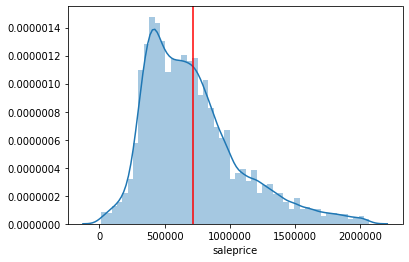

In [59]:
sns.distplot(df1['saleprice'])
plt.axvline(df1['saleprice'].mean(), color = 'red');

In [110]:
for name in df1.columns:
    print(name)

saleprice
sqfttotliving


In [97]:
Y1 = df1['saleprice']
X1 = df1['sqfttotliving']


model1 = sm.OLS(Y1, X1).fit()
predictions1 = model1.predict(X1) # make the predictions by the model

# Print out the statistics
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   0.838
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                          1.489e+05
Date:                Tue, 03 Dec 2019   Prob (F-statistic):                        0.00
Time:                        12:29:46   Log-Likelihood:                     -4.0551e+05
No. Observations:               28747   AIC:                                  8.110e+05
Df Residuals:                   28746   BIC:                                  8.110e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqfttotliving   322.6966      0.836    385.852      0.000     321.057     324.336
==============================================================================
Omnibus:                     2617.575   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17900.452
Skew:                           0.118   Prob(JB):                         0.00
Kurtosis:                       6.859   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
slope = float(model1.params)

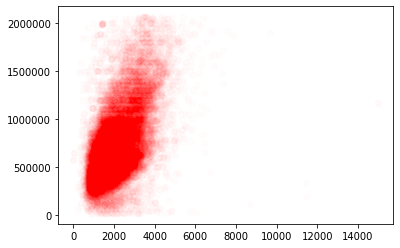

In [96]:
plt.plot(df1['sqfttotliving'], df1['saleprice'], 'ro', alpha = .01)

In [99]:

x_mean = df1['sqfttotliving'].mean()
y_mean = df1['saleprice'].mean()

b = y_mean - x_mean*slope
print(x_mean, y_mean, b)

2098.708073885971 715884.6188819703 715879.167728547


In [105]:
x_line = np.linspace(0, upper_range, 5000)
y_line = x_line*slope

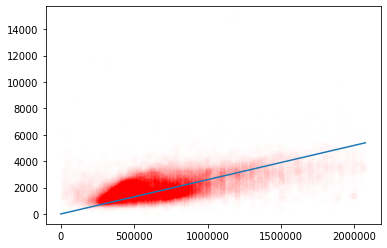

In [106]:
plt.plot(df1['saleprice'], df1['sqfttotliving'], 'ro', alpha = .005)
plt.plot(x_line,y_line)

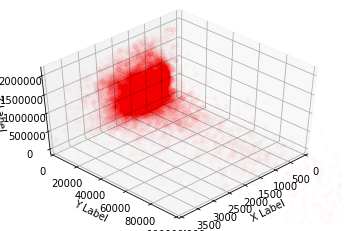

In [144]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['sqft1stfloor']+ df['sqftgarageattached']
y = df['sqftlot']
z = df['saleprice']

ax.set_xlim(0, 4000)
ax.set_ylim(0, 100000)

ax.scatter(x, y, z, c='r', marker='o', alpha = .01)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.view_init(45, 45)
plt.draw()

    